In [47]:
#- Imports e configurações
import warnings
from typing import Dict, Iterable, Optional, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    recall_score,
    make_scorer,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay
  )
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler

warnings.filterwarnings("ignore")

In [ ]:
# Dataset de treino
df_train = pd.read_csv('fetal_health_train_multi.csv')
# Dataset de teste
df_test = pd.read_csv('fetal_health_test_multi.csv')

Basedo no que foi feito durante a EDA as seguintes features foram removidas, pois não seriam muito relevantes para modelagem

#Modelage multiclasse

Fazendo uma modelagem multiclasse, analisando por etapa:
- Modelo sem levar em conta o desbalanceamento das classes e sem tunagem
- Modelo com tunagem e levando em conta as classes, tendo como métrica base para o grid search o recall macro
- Modelo com tunagem e levando em conta as classes, tendo como métrica base para o grid search o F2 score

In [ ]:
#- Separação treino/val/test e escalonamento
x_temp = df_train.drop("fetal_health", axis=1)
y_temp = df_train["fetal_health"]

# Dentro de x_temp, separar 20% -> validação (estratificado)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

x_test = df_test.drop("fetal_health", axis=1)
y_test = df_test["fetal_health"]

scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

##Modelagem sem tunagem

In [ ]:
#- Modelo base (sem tunagem) e predição
rf = RandomForestClassifier()
rf.fit(x_train_scaled, y_train)
y_pred_base = rf.predict(x_test_scaled)

In [ ]:
# Cell 6 (code) - Função de relatório (matriz, report e recall)
def plot_confusion_and_report(y_true, y_pred, labels: Iterable = (1, 2, 3)) -> None:
    """Plota matriz de confusão e imprime classification report + recall macro + F2 macro."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    plt.title("Matriz de Confusão")
    plt.show()

    print(classification_report(y_true, y_pred))
    print("Recall macro:", recall_score(y_true, y_pred, average="macro"))
    f2_macro = fbeta_score(y_true, y_pred, beta=2, average="macro")
    print(f"🎯 F2-score (macro): {f2_macro:.4f}")


=== Resultado do modelo base ===


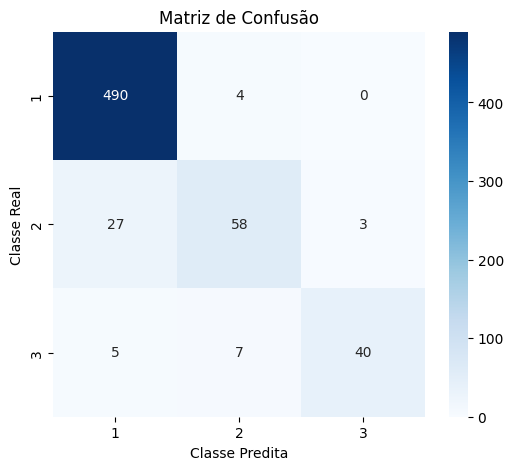

              precision    recall  f1-score   support

         1.0       0.94      0.99      0.96       494
         2.0       0.84      0.66      0.74        88
         3.0       0.93      0.77      0.84        52

    accuracy                           0.93       634
   macro avg       0.90      0.81      0.85       634
weighted avg       0.92      0.93      0.92       634

Recall macro: 0.8067415041099252
🎯 F2-score (macro): 0.8221


In [ ]:
# Avaliar modelo base
print("=== Resultado do modelo base ===")
plot_confusion_and_report(y_test, y_pred_base)

O modelo de **Random Forest baseline**, treinado sem tunagem de hiperparâmetros e sem tratamento do desbalanceamento entre classes, apresentou métricas globais aparentemente satisfatórias, como **recall macro de 0,81** e **F2-score macro de 0,82**; entretanto, esses valores ocultam limitações relevantes quando analisadas as **classes de maior relevância clínica**. Os recalls obtidos para as classes **2 (0,66)** e **3 (0,77)** indicam que uma parcela considerável dos casos suspeitos e patológicos não é corretamente identificada, o que é inadequado em um contexto médico, no qual **falsos negativos possuem alto custo**. Esse comportamento evidencia o viés do modelo em favor da classe majoritária e demonstra que a abordagem baseline **não atende plenamente aos objetivos do projeto**, reforçando a necessidade de **tunagem de hiperparâmetros, estratégias de balanceamento e otimização orientada a métricas sensíveis ao recall** para tornar o modelo mais confiável como apoio à decisão clínica.


##Modelagem com tunagem

In [ ]:
#- Grid de parâmetros para tunagem
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"],
}

Funções que serão utilizadas ao longo da modelagem com tunagem para classificação multiclasse

In [ ]:
# Cell 8 (code) - Funções auxiliares para tuning e thresholds
def train_grid_search(params: Dict, scoring: str, x_data, y_data, cv: int = 5):
    """Executa GridSearchCV para RandomForest e retorna o objeto GridSearchCV."""
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        params,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
    )
    grid.fit(x_data, y_data)
    return grid


def predict_with_thresholds(proba: np.ndarray, thresholds: Dict[int, float], classes: Iterable) -> np.ndarray:
    """Prediz classes usando thresholds personalizados para as classes 2 e 3."""
    class_idx = {c: i for i, c in enumerate(classes)}
    preds = []
    for p in proba:
        if p[class_idx[3]] >= thresholds.get(3, 0.5):
            preds.append(3)
        elif p[class_idx[2]] >= thresholds.get(2, 0.5):
            preds.append(2)
        else:
            preds.append(1)
    return np.array(preds)


def find_best_thresholds(model, x_val, y_val, classes: Iterable = (1, 2, 3),
                         t2_range: Optional[np.ndarray] = None,
                         t3_range: Optional[np.ndarray] = None):
    """Busca por grid os melhores thresholds (t2, t3) usando F2 macro como métrica."""
    if t2_range is None:
        t2_range = np.linspace(0.1, 0.9, 17)
    if t3_range is None:
        t3_range = np.linspace(0.1, 0.9, 17)

    proba = model.predict_proba(x_val)
    best_score = -1.0
    best_thresholds: Dict[int, float] = {}

    for t2 in t2_range:
        for t3 in t3_range:
            thresholds = {2: t2, 3: t3}
            y_pred = predict_with_thresholds(proba, thresholds, classes)
            score = fbeta_score(y_val, y_pred, beta=2, average="macro")
            if score > best_score:
                best_score = score
                best_thresholds = thresholds.copy()

    return best_thresholds, best_score

Após o teste com o modelo simples, sem a tunagem e sem levar em consideração o desbalanceamento das classes percebe-se que os resultados não são muito satisfatórios, agora iremos gerar modelos que levem em consideração esses dois aspectos

###Base de escolha: Recall

In [ ]:
#Cálculo das proporções das classes
pesos = []
ref = y_train.value_counts().max()
for val in y_train.value_counts():
    if(val != ref):
        pesos.append(ref/val)
    else:
        pesos.append(1)
print(pesos)

[1, 5.656441717791411, 9.408163265306122]


Sabendo essa proporção, iremos treinar os modelos com 3 tipos de pesos para as classes:
- 1, 3, 6 => Penalização menor para as classes desbalanceadas
- 1, 4, 8 => Penalização intermediária
- 1, 5, 9 => Penalização mais severa

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [
        None,
        {1:1, 2:3, 3:6},
        {1:1, 2:4, 3:8},
        {1:1, 2:5, 3:9}
    ]
}


Iniciando GridSearch (scoring='recall_macro')...
🏆 Melhores parâmetros (recall_macro):
  class_weight: {1: 1, 2: 5, 3: 9}
  criterion: entropy
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 5
  min_samples_split: 2
  n_estimators: 200
=== Resultado pós-tunagem ===


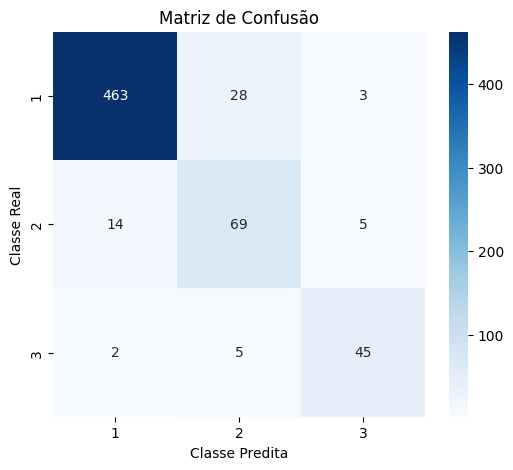

              precision    recall  f1-score   support

         1.0       0.97      0.94      0.95       494
         2.0       0.68      0.78      0.73        88
         3.0       0.85      0.87      0.86        52

    accuracy                           0.91       634
   macro avg       0.83      0.86      0.85       634
weighted avg       0.92      0.91      0.91       634

Recall macro: 0.8622408293460925
🎯 F2-score (macro): 0.8550
Melhores thresholds encontrados: {2: np.float64(0.4), 3: np.float64(0.25)} com F2: 0.8526869845665277
=== Resultado com thresholds ajustados ===


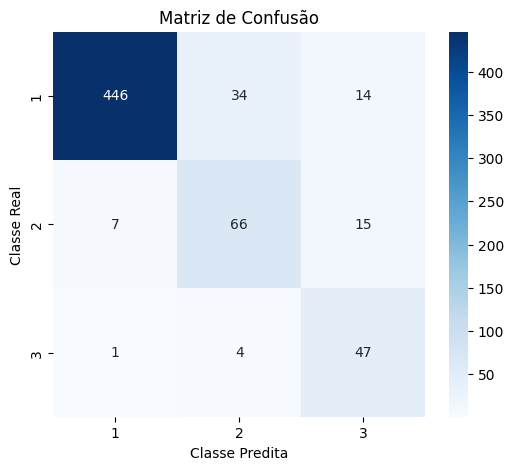

              precision    recall  f1-score   support

         1.0       0.98      0.90      0.94       494
         2.0       0.63      0.75      0.69        88
         3.0       0.62      0.90      0.73        52

    accuracy                           0.88       634
   macro avg       0.75      0.85      0.79       634
weighted avg       0.90      0.88      0.89       634

Recall macro: 0.8522267206477733
🎯 F2-score (macro): 0.8229


In [ ]:
#- GridSearch (scoring por recall_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='recall_macro')...")
grid_search_rec = train_grid_search(param_grid, "recall_macro", x_train_scaled, y_train)
print("🏆 Melhores parâmetros (recall_macro):")
for param, value in grid_search_rec.best_params_.items():
    print(f"  {param}: {value}")

rf_rec = grid_search_rec.best_estimator_
rf_rec.fit(x_train_scaled, y_train)

# Avaliação no teste
y_pred_rec = rf_rec.predict(x_test_scaled)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test, y_pred_rec)

# Busca de thresholds na validação
best_thr, best_score = find_best_thresholds(rf_rec, x_val_scaled, y_val)
print("Melhores thresholds encontrados:", best_thr, "com F2:", best_score)

# Avaliar no teste com thresholds ajustados
proba_test = rf_rec.predict_proba(x_test_scaled)
y_pred_thresh = predict_with_thresholds(proba_test, best_thr, classes=rf_rec.classes_)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test, y_pred_thresh)

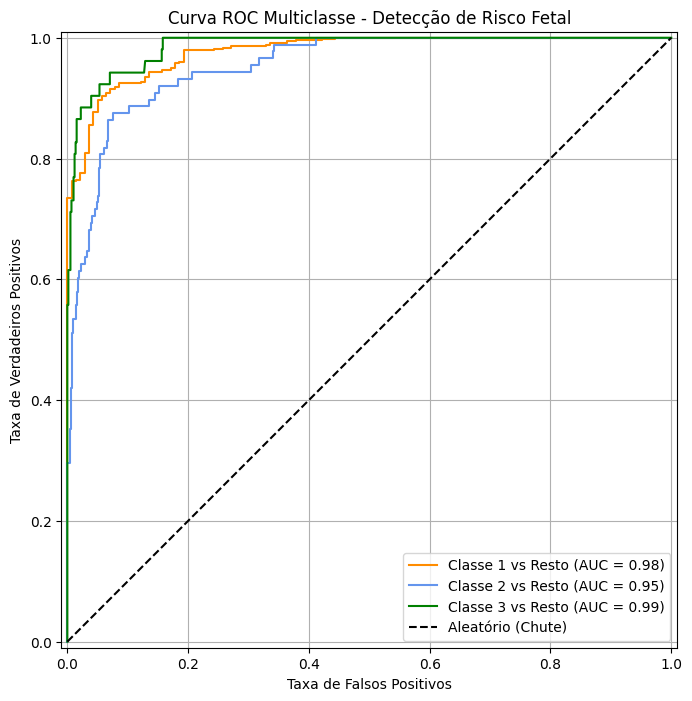

In [50]:
# Avaliação Roc
classes = [1, 2, 3]
lb = LabelBinarizer()
lb.fit(classes)
y_test_roc = lb.transform(y_test)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ["darkorange", "cornflowerblue", "green"]

for i, class_label in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_test_roc[:, i],
        proba_test[:, i],
        name=f"Classe {class_label} vs Resto",
        color=colors[i],
        ax=ax,
        )

plt.plot([0, 1], [0, 1], "k--", label="Aleatório (Chute)")
plt.title("Curva ROC Multiclasse - Detecção de Risco Fetal")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.legend()
plt.grid(True)
plt.show()

###Base de escolha do modelo: F2 score + pesos

In [ ]:
#- Gerando a métrica F2 score para poder ser utilizada no grid search que é feito
f2_macro = make_scorer(
    fbeta_score,
    beta=2,
    average='macro'
)

Iniciando GridSearch (scoring='f2_macro')...
🏆 Melhores parâmetros (f2_macro):
  class_weight: {1: 1, 2: 5, 3: 9}
  criterion: entropy
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 5
  min_samples_split: 2
  n_estimators: 200
=== Resultado pós-tunagem ===


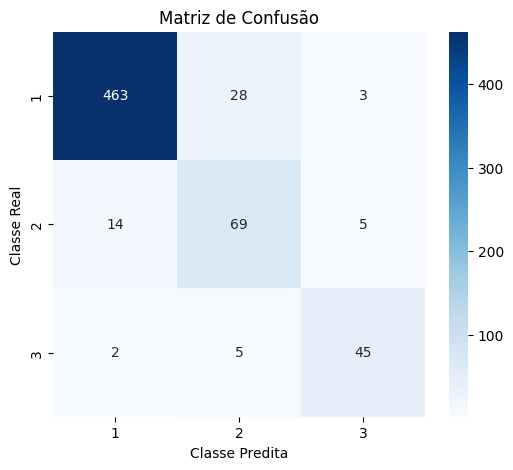

              precision    recall  f1-score   support

         1.0       0.97      0.94      0.95       494
         2.0       0.68      0.78      0.73        88
         3.0       0.85      0.87      0.86        52

    accuracy                           0.91       634
   macro avg       0.83      0.86      0.85       634
weighted avg       0.92      0.91      0.91       634

Recall macro: 0.8622408293460925
🎯 F2-score (macro): 0.8550
Melhores thresholds encontrados: {2: np.float64(0.4), 3: np.float64(0.25)} com F2: 0.8526869845665277
=== Resultado com thresholds ajustados ===


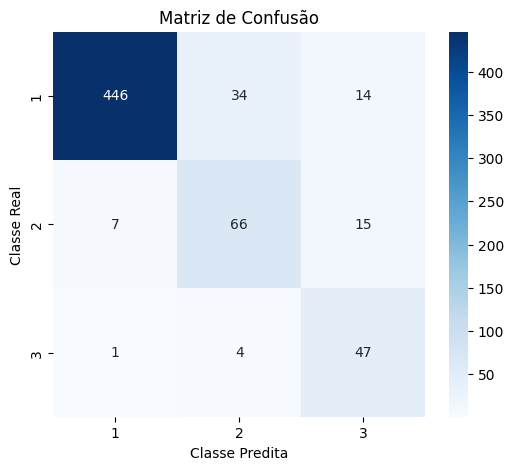

              precision    recall  f1-score   support

         1.0       0.98      0.90      0.94       494
         2.0       0.63      0.75      0.69        88
         3.0       0.62      0.90      0.73        52

    accuracy                           0.88       634
   macro avg       0.75      0.85      0.79       634
weighted avg       0.90      0.88      0.89       634

Recall macro: 0.8522267206477733
🎯 F2-score (macro): 0.8229


In [ ]:
#- GridSearch (scoring por f2_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='f2_macro')...")
grid_search_f2 = train_grid_search(param_grid, f2_macro, x_train_scaled, y_train)
print("🏆 Melhores parâmetros (f2_macro):")
for param, value in grid_search_f2.best_params_.items():
    print(f"  {param}: {value}")

rf_f2 = grid_search_f2.best_estimator_
rf_f2.fit(x_train_scaled, y_train)

# Avaliação no teste
y_pred_f2 = rf_f2.predict(x_test_scaled)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test, y_pred_f2)

# Busca de thresholds na validação
best_thr_f2, best_score_f2 = find_best_thresholds(rf_f2, x_val_scaled, y_val)
print("Melhores thresholds encontrados:", best_thr_f2, "com F2:", best_score_f2)

# Avaliar no teste com thresholds ajustados
proba_test_f2 = rf_f2.predict_proba(x_test_scaled)
y_pred_thresh_f2 = predict_with_thresholds(proba_test_f2, best_thr_f2, classes=rf_f2.classes_)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test, y_pred_thresh_f2)

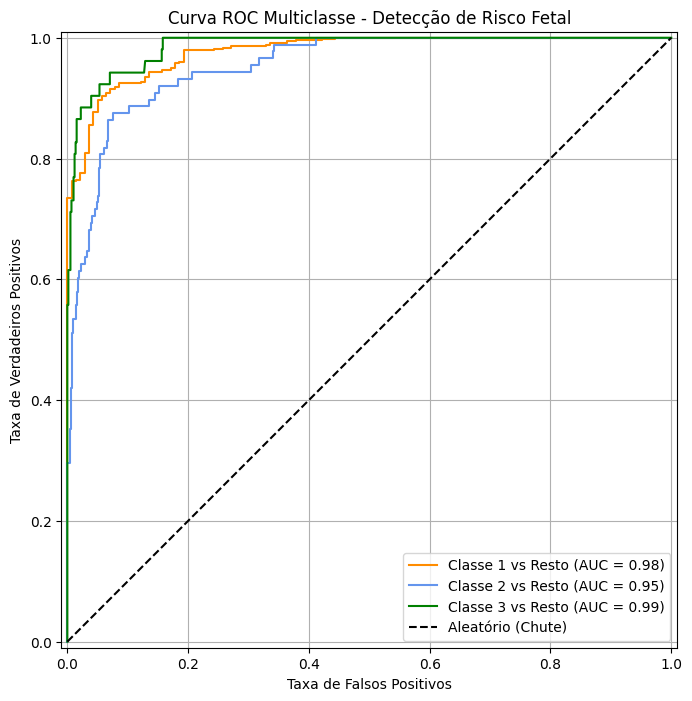

In [49]:
# Avaliação Roc
classes = [1, 2, 3]
lb = LabelBinarizer()
lb.fit(classes)
y_test_roc = lb.transform(y_test)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ["darkorange", "cornflowerblue", "green"]

for i, class_label in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_test_roc[:, i],
        proba_test_f2[:, i],
        name=f"Classe {class_label} vs Resto",
        color=colors[i],
        ax=ax,
        )

plt.plot([0, 1], [0, 1], "k--", label="Aleatório (Chute)")
plt.title("Curva ROC Multiclasse - Detecção de Risco Fetal")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.legend()
plt.grid(True)
plt.show()

A comparação entre as duas estratégias de tunagem evidencia que, para esse cenário, o **GridSearch orientado pelo recall macro** e o **GridSearch orientado pelo F2-score** convergiram para **o mesmo modelo final**, apresentando resultados idênticos em todas as métricas avaliadas. Ambos os modelos alcançaram **recall macro de 0,85** e **F2-score macro de 0,82**, além de recalls elevados nas **classes de maior relevância clínica**, com destaque para a classe **3**, que atingiu **recall de 0,90**, e desempenho consistente na classe **2**, com **recall de 0,75**. Essa convergência ocorre porque, em um problema multiclasse desbalanceado com foco na redução de falsos negativos, o **F2-score é fortemente influenciado pelo recall**, fazendo com que a otimização por ambas as métricas privilegie o mesmo conjunto de hiperparâmetros. Assim, os resultados reforçam que a tunagem adotada está alinhada aos objetivos do projeto, priorizando a sensibilidade nas classes críticas e a segurança no apoio à decisão clínica.


##Feature importance

Analisando quais features foram mais importantes para o modelo baseado no melhor modelo que foi o que teve como base de escolha f2_score

In [ ]:
# Feature importance
feature_names = df_train.columns
importances = rf_rec.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  abnormal_short_term_variability: 0.228
  prolongued_decelerations: 0.138
  baseline value: 0.137
  accelerations: 0.122
  histogram_variance: 0.112


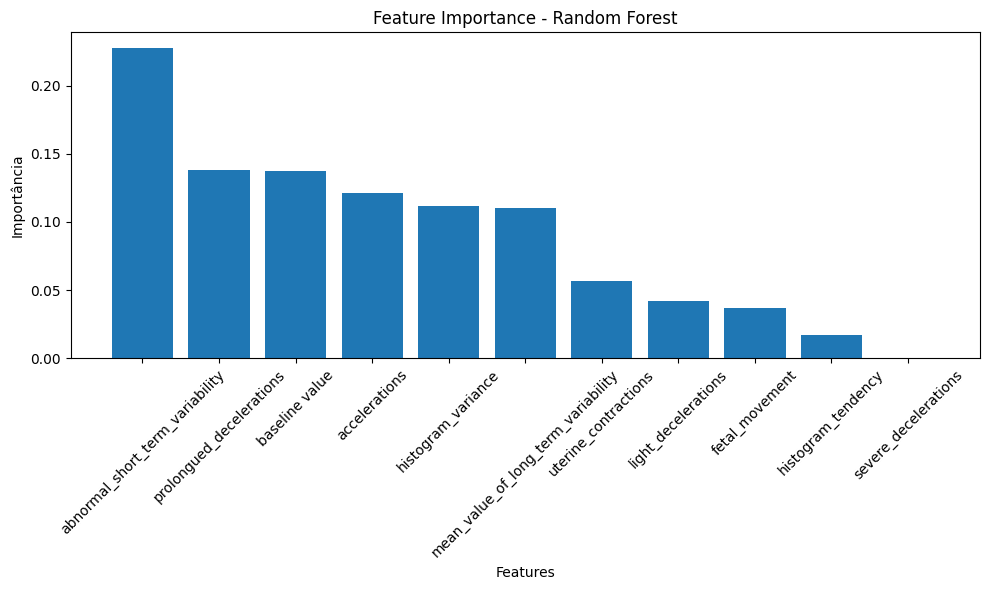

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Random Forest')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

#Modelage binária

In [ ]:
#- Separação treino/val/test e escalonamento
x_temp = df_train.drop("fetal_health", axis=1)
y_temp = df_train["fetal_health"]

#Fazer com que a classe 3 tenha o mesmo valor que a classe 2
y_temp = y_temp.replace(3, 2)

# Dentro de x_temp, separar 20% -> validação (estratificado)
x_train_bin, x_val_bin, y_train_bin, y_val_bin = train_test_split(
    x_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

x_test_bin = df_test.drop("fetal_health", axis=1)
y_test_bin = df_test["fetal_health"]

y_test_bin = y_test_bin.replace(3, 2)

scaler = RobustScaler()
x_train_scaled_bin = scaler.fit_transform(x_train_bin)
x_val_scaled_bin = scaler.transform(x_val_bin)
x_test_scaled_bin = scaler.transform(x_test_bin)

##Modelagem sem tunagem

=== Resultado do modelo base ===


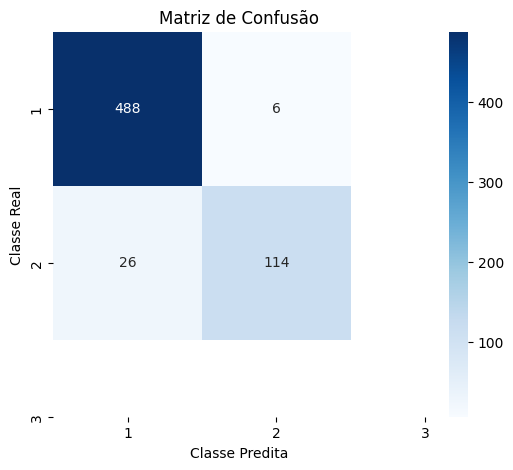

              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97       494
         2.0       0.95      0.81      0.88       140

    accuracy                           0.95       634
   macro avg       0.95      0.90      0.92       634
weighted avg       0.95      0.95      0.95       634

Recall macro: 0.90106998264893
🎯 F2-score (macro): 0.9091


In [ ]:
#- Modelo base (sem tunagem) e predição
rf_bin = RandomForestClassifier()
rf_bin.fit(x_train_scaled_bin, y_train_bin)
y_pred_base_bin = rf_bin.predict(x_test_scaled_bin)

# Avaliar modelo base
print("=== Resultado do modelo base ===")
plot_confusion_and_report(y_test_bin, y_pred_base_bin)

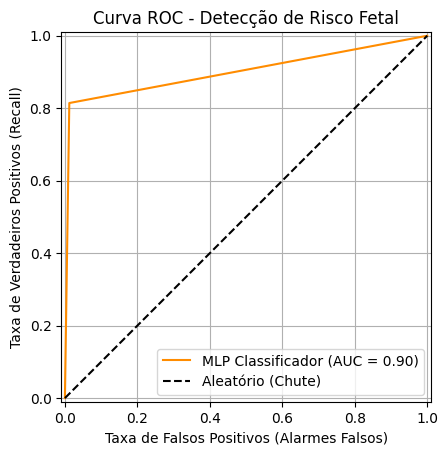

In [46]:
# Plot da curva do AUC-ROC Score
RocCurveDisplay.from_predictions(
    y_test_bin,
    y_pred_base_bin,
    name="MLP Classificador",
    pos_label=2,    # Dizendo que a classe '2' é o nosso alvo (Risco)
    color="darkorange",
    )

# Estética do gráfico
plt.plot([0, 1], [0, 1], "k--", label="Aleatório (Chute)") # Linha pontilhada de referência
plt.title("Curva ROC - Detecção de Risco Fetal")
plt.xlabel("Taxa de Falsos Positivos (Alarmes Falsos)")
plt.ylabel("Taxa de Verdadeiros Positivos (Recall)")
plt.legend()
plt.grid(True)
plt.show()

No cenário de **classificação binária**, o modelo de **Random Forest sem tunagem** apresentou desempenho elevado nas métricas de interesse, com **recall macro de 0,90** e **F2-score macro de 0,91**, indicando boa sensibilidade na identificação da classe positiva. Esse ganho em relação ao cenário multiclasse é esperado, uma vez que a reformulação do problema reduz a complexidade da tarefa de classificação; contudo, os resultados ainda devem ser interpretados com cautela. Apesar do desempenho inicial favorável, a ausência de **tunagem de hiperparâmetros** e de **estratégias específicas para lidar com o desbalanceamento** pode limitar a robustez do modelo em situações mais críticas, reforçando que essa abordagem representa um **baseline** e não uma solução final plenamente adequada ao objetivo de apoio à decisão clínica.


##Modelagem com tunagem

In [ ]:
ref = y_train_bin.value_counts().max()
for val in y_train_bin.value_counts():
    if(val != ref):
        print(ref/val)

3.515267175572519


Fazendo a modelagem sem tunagem, percebe-se que os resultados não foram ruins, porém tentaremos melhorar usando a tunagem mais o uso de pesos para as classes:
- 1, 2 => Penalização suave
- 1, 4 => Penalização intermediária
- 1, 5 => Penalização severa

In [ ]:
param_grid_bin = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [
        None,
        {1:1, 2:2},
        {1:1, 2:4},
        {1:1, 2:5}
    ]
}

Fazendo um grid search tendo como critério de decisão a acurácia

In [ ]:

def predict_binary_with_threshold(
    proba: np.ndarray,
    threshold: float,
    classes: Sequence[int],
    positive_class: int,
) -> np.ndarray:
    """Prediz rótulos binários a partir de probabilidades aplicando um threshold.

    Args:
        proba: Matriz de probabilidades com forma (n_samples, n_classes).
        threshold: Threshold para a classe positiva.
        classes: Sequência com os rótulos das classes (ex.: [0, 1] ou [1, 2]).
        positive_class: Rótulo da classe considerada positiva.

    Returns:
        Array de previsões com os rótulos correspondentes (positive_class ou negative_class).
    """
    class_idx = {c: i for i, c in enumerate(classes)}
    if positive_class not in class_idx:
        raise ValueError("positive_class must be present in classes")

    pos_idx = class_idx[positive_class]

    negative_candidates = [c for c in classes if c != positive_class]
    if not negative_candidates:
        raise ValueError("classes must contain at least one negative class")
    negative_class = negative_candidates[0]

    preds = []
    for p in proba:
        if p[pos_idx] >= threshold:
            preds.append(positive_class)
        else:
            preds.append(negative_class)

    return np.array(preds)


def find_best_threshold_binary(
    model,
    x_val: np.ndarray,
    y_val: np.ndarray,
    classes: Sequence[int],
    positive_class: int,
    t_range: Optional[np.ndarray] = None,
) -> Tuple[float, float]:
    """Encontra o melhor threshold para classificação binária maximizando F2.

    Args:
        model: Modelo com método predict_proba.
        x_val: Dados de validação (features).
        y_val: Rótulos de validação.
        classes: Sequência com os rótulos das classes (ex.: [0, 1] ou [1, 2]).
        positive_class: Rótulo da classe positiva para a métrica.
        t_range: Opcional array de thresholds a testar. Se None, usa np.linspace(0.05, 0.95, 37).

    Returns:
        Tupla (best_threshold, best_score) onde best_score é o F2 (beta=2) correspondente.
    """
    if t_range is None:
        t_range = np.linspace(0.05, 0.95, 37)

    proba = model.predict_proba(x_val)

    best_score = -1.0
    best_threshold = 0.5

    for t in t_range:
        y_pred = predict_binary_with_threshold(
            proba=proba,
            threshold=float(t),
            classes=classes,
            positive_class=positive_class,
        )

        score = fbeta_score(
            y_val,
            y_pred,
            beta=2,
            average="binary",
            pos_label=positive_class,
        )

        if score > best_score:
            best_score = float(score)
            best_threshold = float(t)

    return best_threshold, best_score

###Base de escolha: Recall macro + pesos

Iniciando GridSearch (scoring='recall_macro')...
🏆 Melhores parâmetros (recall_macro):
  class_weight: {1: 1, 2: 5}
  criterion: entropy
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 5
  min_samples_split: 2
  n_estimators: 200
=== Resultado pós-tunagem ===


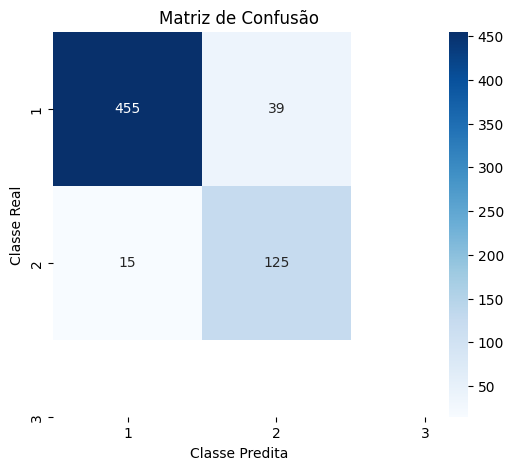

              precision    recall  f1-score   support

         1.0       0.97      0.92      0.94       494
         2.0       0.76      0.89      0.82       140

    accuracy                           0.91       634
   macro avg       0.87      0.91      0.88       634
weighted avg       0.92      0.91      0.92       634

Recall macro: 0.9069548872180451
🎯 F2-score (macro): 0.8967
Melhores thresholds encontrados: 0.6 com F2: 0.8769230769230769
=== Resultado com thresholds ajustados ===


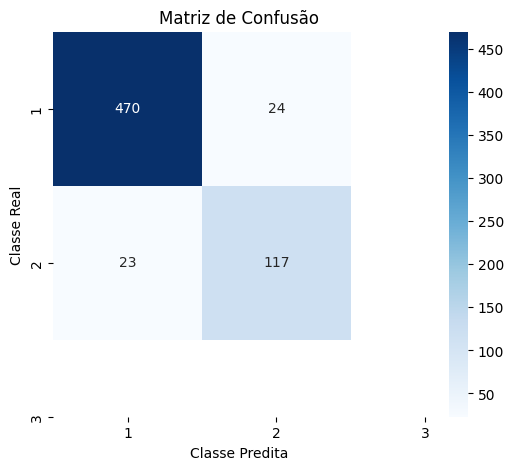

              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       494
         2.0       0.83      0.84      0.83       140

    accuracy                           0.93       634
   macro avg       0.89      0.89      0.89       634
weighted avg       0.93      0.93      0.93       634

Recall macro: 0.8935656448814344
🎯 F2-score (macro): 0.8932


In [37]:
# Cell 9 (code) - GridSearch (scoring por recall_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='recall_macro')...")
grid_search_rec_bin = train_grid_search(param_grid_bin, "recall_macro", x_train_scaled_bin, y_train_bin)
print("🏆 Melhores parâmetros (recall_macro):")
for param, value in grid_search_rec_bin.best_params_.items():
    print(f"  {param}: {value}")

rf_rec_bin = grid_search_rec_bin.best_estimator_
rf_rec_bin.fit(x_train_scaled_bin, y_train_bin)

# Avaliação no teste
y_pred_rec_bin = rf_rec_bin.predict(x_test_scaled_bin)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test_bin, y_pred_rec_bin)

# Busca de thresholds na validação
best_thr_bin, best_score_bin = find_best_threshold_binary(rf_rec_bin, x_val_scaled_bin, y_val_bin, classes=rf_rec_bin.classes_, positive_class=2)
print("Melhores thresholds encontrados:", best_thr_bin, "com F2:", best_score_bin)

# Avaliar no teste com thresholds ajustados
proba_test_bin = rf_rec_bin.predict_proba(x_test_scaled_bin)
y_pred_thresh = predict_binary_with_threshold(proba_test_bin, best_thr_bin, classes=rf_rec_bin.classes_, positive_class=2)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test_bin, y_pred_thresh)


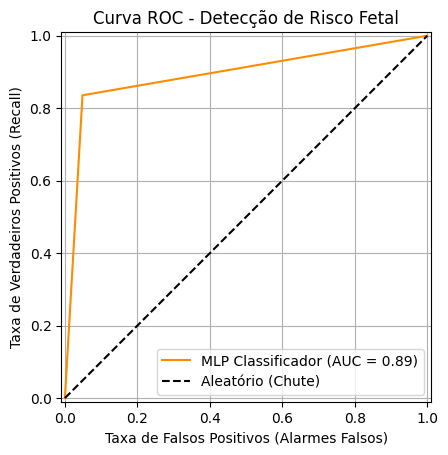

In [45]:
# Plot da curva do AUC-ROC Score
RocCurveDisplay.from_predictions(
    y_test_bin,
    y_pred_thresh,
    name="MLP Classificador",
    pos_label=2,    # Dizendo que a classe '2' é o nosso alvo (Risco)
    color="darkorange",
    )

# Estética do gráfico
plt.plot([0, 1], [0, 1], "k--", label="Aleatório (Chute)") # Linha pontilhada de referência
plt.title("Curva ROC - Detecção de Risco Fetal")
plt.xlabel("Taxa de Falsos Positivos (Alarmes Falsos)")
plt.ylabel("Taxa de Verdadeiros Positivos (Recall)")
plt.legend()
plt.grid(True)
plt.show()

###Base de escolha do modelo: F2 score + pesos

Iniciando GridSearch (scoring='f2_macro')...
🏆 Melhores parâmetros (f2_macro):
  class_weight: {1: 1, 2: 4}
  criterion: entropy
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200
=== Resultado pós-tunagem ===


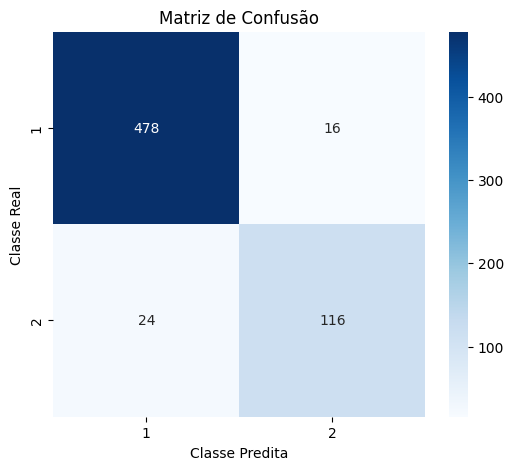

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       494
         2.0       0.88      0.83      0.85       140

    accuracy                           0.94       634
   macro avg       0.92      0.90      0.91       634
weighted avg       0.94      0.94      0.94       634

Recall macro: 0.8980913823019087
🎯 F2-score (macro): 0.9013
Melhores thresholds encontrados: 0.475 com F2: 0.8950617283950617
=== Resultado com thresholds ajustados ===


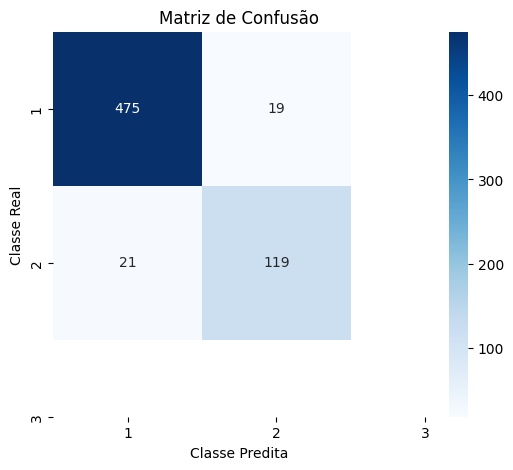

              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       494
         2.0       0.86      0.85      0.86       140

    accuracy                           0.94       634
   macro avg       0.91      0.91      0.91       634
weighted avg       0.94      0.94      0.94       634

Recall macro: 0.9057692307692308
🎯 F2-score (macro): 0.9066


In [38]:
# Cell 9 (code) - GridSearch (scoring por f2_macro), re-treino e avaliação final
print("Iniciando GridSearch (scoring='f2_macro')...")
grid_search_f2_bin = train_grid_search(param_grid_bin, f2_macro, x_train_scaled_bin, y_train_bin)
print("🏆 Melhores parâmetros (f2_macro):")
for param, value in grid_search_f2_bin.best_params_.items():
    print(f"  {param}: {value}")

rf_f2_bin = grid_search_f2_bin.best_estimator_
rf_f2_bin.fit(x_train_scaled_bin, y_train_bin)

# Avaliação no teste
y_pred_f2_bin = rf_f2_bin.predict(x_test_scaled_bin)
print("=== Resultado pós-tunagem ===")
plot_confusion_and_report(y_test_bin, y_pred_f2_bin, labels=(1, 2))

# Busca de thresholds na validação
best_thr_f2_bin, best_score_f2_bin = find_best_threshold_binary(rf_f2_bin, x_val_scaled_bin, y_val_bin, classes=rf_f2_bin.classes_, positive_class=2)
print("Melhores thresholds encontrados:", best_thr_f2_bin, "com F2:", best_score_f2_bin)

# Avaliar no teste com thresholds ajustados
proba_test_f2_bin = rf_f2_bin.predict_proba(x_test_scaled_bin)
y_pred_f2_thresh = predict_binary_with_threshold(proba_test_f2_bin, best_thr_f2_bin, classes=rf_f2_bin.classes_, positive_class=2)
print("=== Resultado com thresholds ajustados ===")
plot_confusion_and_report(y_test_bin, y_pred_f2_thresh)


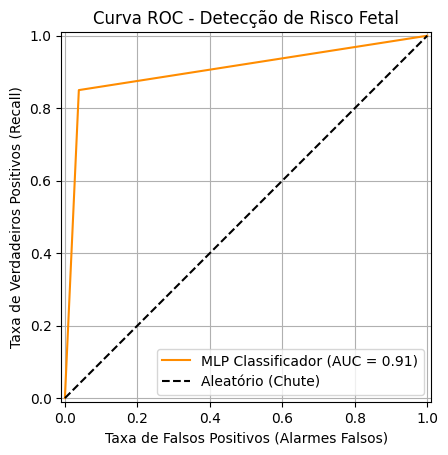

In [44]:
# Plot da curva do AUC-ROC Score
RocCurveDisplay.from_predictions(
    y_test_bin,
    y_pred_f2_thresh,
    name="MLP Classificador",
    pos_label=2,    # Dizendo que a classe '2' é o nosso alvo (Risco)
    color="darkorange",
    )

# Estética do gráfico
plt.plot([0, 1], [0, 1], "k--", label="Aleatório (Chute)") # Linha pontilhada de referência
plt.title("Curva ROC - Detecção de Risco Fetal")
plt.xlabel("Taxa de Falsos Positivos (Alarmes Falsos)")
plt.ylabel("Taxa de Verdadeiros Positivos (Recall)")
plt.legend()
plt.grid(True)
plt.show()

No cenário de **classificação binária com tunagem**, os modelos obtidos a partir do **GridSearch orientado por recall macro** e por **F2-score** apresentaram desempenhos próximos, porém **não idênticos**, evidenciando diferenças sutis na forma como cada métrica direciona a otimização. A tunagem baseada em **recall macro** resultou em desempenho equilibrado entre as classes, com **recall macro de 0,89** e **F2-score macro de 0,89**, enquanto a otimização orientada pelo **F2-score** produziu valores ligeiramente superiores, alcançando **recall macro de 0,91** e **F2-score macro de 0,91**, além de melhor sensibilidade da classe positiva (**recall de 0,85 vs. 0,84**). Essas diferenças indicam que, embora o F2-score seja fortemente influenciado pelo recall em problemas binários desbalanceados, sua otimização pode favorecer soluções com melhor equilíbrio entre recall e precisão. Ainda assim, ambos os resultados permanecem alinhados ao objetivo central do projeto de **minimizar falsos negativos**, demonstrando que as duas estratégias de tunagem são adequadas, com leve vantagem para a otimização baseada em **F2-score** neste cenário específico.


##Feature Importance

Analisando quais features foram mais importantes para o modelo

In [40]:
# Feature importance
feature_names = df_train.columns
importances = rf_f2_bin.feature_importances_
indices = np.argsort(importances)[::-1]

In [41]:
print(f"\n📊 Feature Importance (Random Forest):")
for i in range(min(5, len(indices))):
    idx = indices[i]
    print(f"  {feature_names[idx]}: {importances[idx]:.3f}")


📊 Feature Importance (Random Forest):
  abnormal_short_term_variability: 0.282
  accelerations: 0.200
  baseline value: 0.101
  histogram_variance: 0.101
  uterine_contractions: 0.086


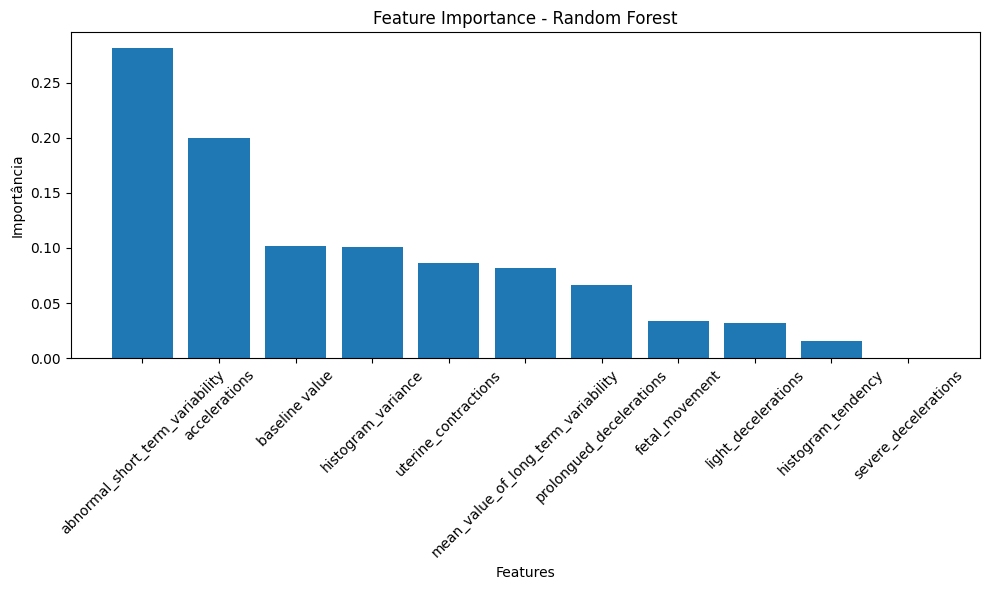

In [42]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Feature Importance - Random Forest')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()